In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown

In [2]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "D://face/", label_mode=None, image_size=(64, 64), batch_size=128
)
dataset = dataset.map(lambda x: x / 255.0)

Found 63564 files belonging to 1 classes.


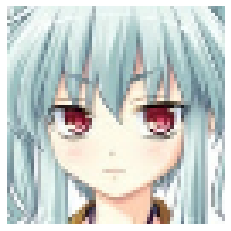

In [3]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [4]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        # layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        # layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1)               

In [5]:
latent_dim = 100

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(30, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       131136    
 ranspose)                                                       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0 

In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [7]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            plt.imshow(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [8]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
gan.fit(dataset, epochs=150)

Epoch 1/150
497/497 [==============================] - 1545s 3s/step - d_loss: 0.3248 - g_loss: 2.0676
Epoch 2/150
497/497 [==============================] - 1936s 4s/step - d_loss: 0.4484 - g_loss: 2.1622
Epoch 3/150
497/497 [==============================] - 1101s 2s/step - d_loss: 0.5545 - g_loss: 1.7024
Epoch 4/150
497/497 [==============================] - 1104s 2s/step - d_loss: 0.4527 - g_loss: 1.6698
Epoch 5/150
497/497 [==============================] - 1064s 2s/step - d_loss: 0.4967 - g_loss: 1.3269
Epoch 6/150
497/497 [==============================] - 1079s 2s/step - d_loss: 0.4284 - g_loss: 1.4467
Epoch 7/150
497/497 [==============================] - 2551s 5s/step - d_loss: 0.5178 - g_loss: 1.5260
Epoch 8/150
497/497 [==============================] - 1065s 2s/step - d_loss: 0.6106 - g_loss: 2.1154
Epoch 9/150
497/497 [==============================] - 1046s 2s/step - d_loss: 0.4186 - g_loss: 1.4845
Epoch 10/150
497/497 [==============================] - 1095s 2s/step - d

497/497 [==============================] - 1073s 2s/step - d_loss: 0.6894 - g_loss: 0.8819
Epoch 80/150
497/497 [==============================] - 1053s 2s/step - d_loss: 0.6868 - g_loss: 0.8824
Epoch 81/150
497/497 [==============================] - 1073s 2s/step - d_loss: 0.7353 - g_loss: 0.8811
Epoch 82/150
497/497 [==============================] - 1067s 2s/step - d_loss: 0.7012 - g_loss: 0.8932
Epoch 83/150
497/497 [==============================] - 1062s 2s/step - d_loss: 0.6960 - g_loss: 0.8471
Epoch 84/150
497/497 [==============================] - 1060s 2s/step - d_loss: 0.7114 - g_loss: 0.8929
Epoch 85/150
497/497 [==============================] - 1091s 2s/step - d_loss: 0.7012 - g_loss: 0.9173
Epoch 86/150
497/497 [==============================] - 1062s 2s/step - d_loss: 0.7469 - g_loss: 0.8604
Epoch 87/150
497/497 [==============================] - 1051s 2s/step - d_loss: 0.7006 - g_loss: 0.8466
Epoch 88/150
497/497 [==============================] - 1051s 2s/step - d_los

In [38]:
test = generator.predict( tf.random.normal(shape=(20, latent_dim)))

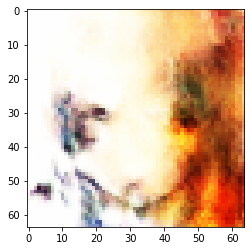

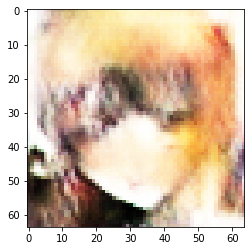

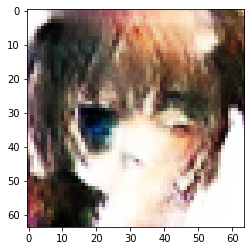

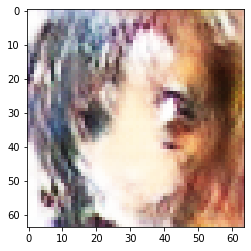

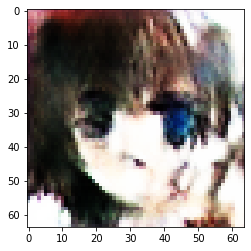

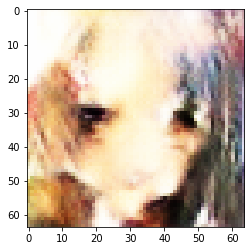

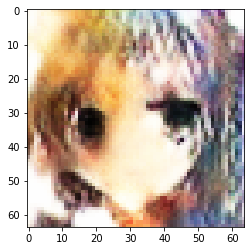

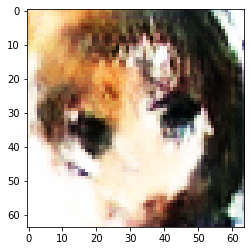

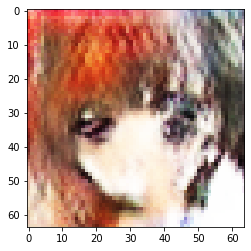

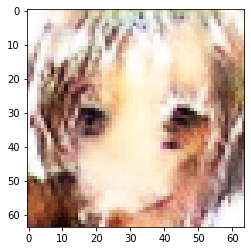

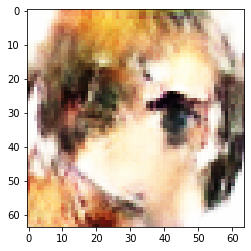

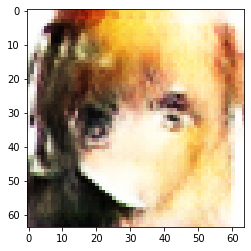

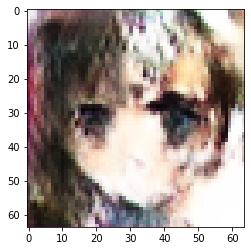

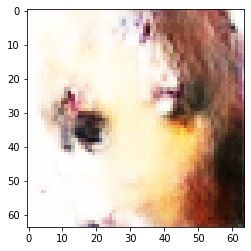

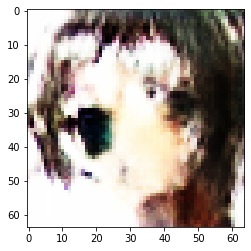

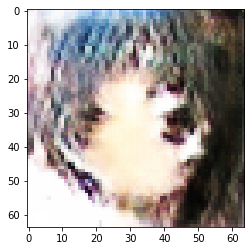

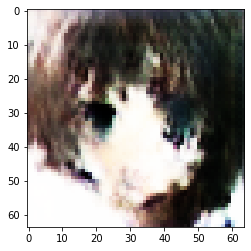

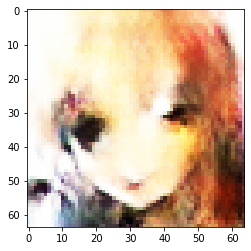

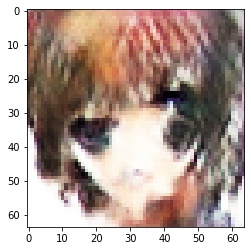

In [39]:
for i in range (0,19):
    plt.imshow(test[i])
    plt.show()